In [1]:
import pandas as pd
from datetime import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
listings=pd.read_csv("../source/clean/listings_all_ml.zip")

In [3]:
listings=listings.dropna()
len(listings)

302597

In [4]:
# create training and validation sets
traintest_set=listings.iloc[0:(round(len(listings)*0.9)),:]
validation_set=listings.iloc[(round(len(listings)*0.9)):len(listings),:]

In [5]:
# create x and y variables
X=traintest_set.drop(["SoldPrice"],axis=1)
y=traintest_set["SoldPrice"].values
X_validation=validation_set.drop(["SoldPrice"],axis=1)
y_validation=validation_set["SoldPrice"].values
print(X.shape,y.shape,X_validation.shape,y_validation.shape)

(272337, 599) (272337,) (30260, 599) (30260,)


In [6]:
# scale the predictors
from sklearn.preprocessing import StandardScaler
X_scaler=StandardScaler().fit(X)
X_scaled=X_scaler.transform(X)
X_validation_scaled=X_scaler.transform(X_validation)

In [7]:
# using random forest regressor
from sklearn.ensemble import RandomForestRegressor
rfReg=RandomForestRegressor(random_state=31)

In [8]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

time_split = TimeSeriesSplit(n_splits=5)
score=cross_val_score(rfReg,X_scaled,y,cv=time_split,scoring="r2",n_jobs=4)
print(score)

[0.69148424 0.68134651 0.71513532 0.73855096 0.76096649]


In [9]:
# use feature importance to select features to include in final model
rfReg.fit(X_scaled,y)

importances = pd.Series(data=rfReg.feature_importances_ , index= X.columns)
importance_sorted=importances.sort_values(ascending=False)

importance_sorted[0:50]

Longitude                         0.165527
Bath                              0.158358
Latitude                          0.153948
Suburb_TOORAK                     0.064603
Bed                               0.059223
SoldYear                          0.056115
SoldMethod_SoldByAuction          0.041924
swimmingpool                      0.040605
Rate per 100,000 population       0.025446
Type_ApartmentUnitFlat            0.025265
Car                               0.021906
tenniscourt                       0.019835
Offence Count                     0.018727
SoldDay                           0.017863
Floorplan_True                    0.017083
SoldMonth                         0.013495
Type_House                        0.009182
Suburb_BRIGHTON                   0.004089
study                             0.003907
heating                           0.003529
secureparking                     0.003474
Type_Townhouse                    0.003005
ensuite                           0.002717
gas        

In [10]:
# only select top 20 features
features=importance_sorted[0:20].index.tolist()
print(features)

X2=traintest_set[features]
X2_validation=validation_set[features]

X2_scaler=StandardScaler().fit(X2)
X2_scaled=X2_scaler.transform(X2)
X2_validation_scaled=X2_scaler.transform(X2_validation)

['Longitude', 'Bath', 'Latitude', 'Suburb_TOORAK', 'Bed', 'SoldYear', 'SoldMethod_SoldByAuction', 'swimmingpool', 'Rate per 100,000 population', 'Type_ApartmentUnitFlat', 'Car', 'tenniscourt', 'Offence Count', 'SoldDay', 'Floorplan_True', 'SoldMonth', 'Type_House', 'Suburb_BRIGHTON', 'study', 'heating']


In [11]:
rfReg2=RandomForestRegressor(random_state=14)
score=cross_val_score(rfReg2,X2_scaled,y,cv=time_split,scoring="r2",n_jobs=4)
print(score)

[0.69059517 0.69735657 0.71480945 0.73643085 0.75244666]


In [12]:
rfReg2.fit(X2_scaled, y)

RandomForestRegressor(random_state=14)

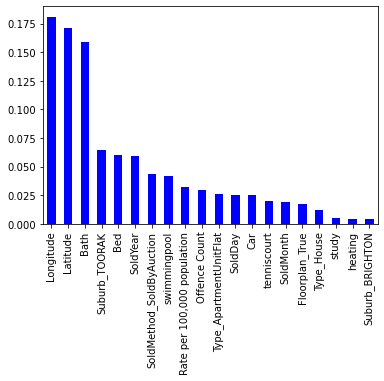

In [13]:
importances = pd.Series(data=rfReg2.feature_importances_ , index= X2.columns)
importance_sorted=importances.sort_values(ascending=False)
importance_sorted.plot(kind="bar", color="blue")

In [14]:
# end up not running randomizedsearchcv because it took too long
# from sklearn.model_selection import RandomizedSearchCV
# param_grid = { 
#     #'n_estimators': [100,200,300,400,500,600,700,800,900,1000],
#     'n_estimators': [100,300,500,700,900],
#     'max_features': ['auto','sqrt'],
#     'max_depth':[None],
#     'min_samples_split':[2],
#     #'max_depth' : [None,1,2,3,4,5,10,15],
#     #'criterion' :['mse','mae'],
#     #'min_samples_split':[2,5,10],
#     'bootstrap' :[True, False]
# }

rf_random = RandomizedSearchCV(estimator=rfReg2,param_distributions=param_grid, 
                               n_iter=200,cv=time_split,verbose=3,random_state=42,n_jobs=-1)

In [15]:
rf_random.fit(X2_scaled,y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/yannyinc/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 20 is smaller than n_iter=200. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 90.5min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   estimator=RandomForestRegressor(random_state=14), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2],
                                        'n_estimators': [100, 300, 500, 700,
                                                         900]},
                   random_state=42, verbose=3)

In [16]:
print(rf_random.best_params_)
print(rf_random.best_score_)

{'n_estimators': 700, 'min_samples_split': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
0.6754621204848457


In [14]:
# trying a different model
import xgboost as xgb
xgb_model = xgb.XGBRegressor() 
score=cross_val_score(xgb_model,X2_scaled,y,cv=time_split,scoring="r2",n_jobs=4)
print(score)

[0.6899381  0.70045529 0.72045603 0.75479171 0.77937699]


In [15]:
rf_final=RandomForestRegressor(n_estimators=700,min_samples_split=2,max_features='auto',
                                 max_depth=None,bootstrap=True,random_state=42)
xgb_final=xgb.XGBRegressor(n_estimators=700,random_state=42)

In [16]:
rf_final.fit(X2_scaled,y)
xgb_final.fit(X2_scaled,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=700, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
# save final model
import joblib
print(X2_validation.columns)
joblib.dump(rf_final, '../model/rf_final.sav')
joblib.dump(X2_scaler, '../model/std_scaler.bin', compress=True)

Index(['Longitude', 'Bath', 'Latitude', 'Suburb_TOORAK', 'Bed', 'SoldYear',
       'SoldMethod_SoldByAuction', 'swimmingpool',
       'Rate per 100,000 population', 'Type_ApartmentUnitFlat', 'Car',
       'tenniscourt', 'Offence Count', 'SoldDay', 'Floorplan_True',
       'SoldMonth', 'Type_House', 'Suburb_BRIGHTON', 'study', 'heating'],
      dtype='object')


['../model/std_scaler.bin']

In [17]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

scores = pd.DataFrame()
for model in [rf_final,xgb_final]:
    predictions = model.predict(X2_validation_scaled)
    mae = round(mean_absolute_error(y_validation, predictions), 4)
    mse = round(mean_squared_error(y_validation, predictions), 4)
    r2 = round(r2_score(y_validation, predictions), 4)
    m_errors = round(max_error(y_validation, predictions),4)
    exp_variance = round(explained_variance_score(y_validation, predictions),4)
    scores[str(model)] = [mae, mse, r2, m_errors, exp_variance]
scores.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 'Max Error', 'Explained Variance']

In [18]:
# both xgb and rf have similar performance
scores.columns=['random forest regression','xgb regressor']
scores

,random forest regression,xgb regressor
Mean Absolute Error,1.449053e+05,1.537610e+05
Mean Squared Error,9.040135e+10,8.866929e+10
R^2,7.625000e-01,7.671000e-01
Max Error,1.130729e+07,1.215806e+07
Explained Variance,7.648000e-01,7.764000e-01


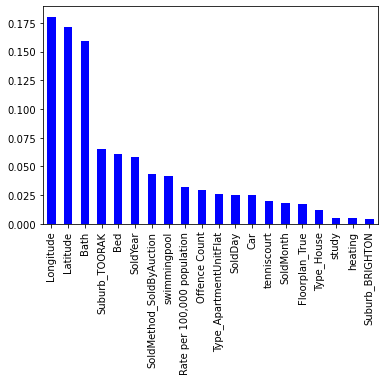

In [19]:
importances = pd.Series(data=rf_final.feature_importances_ , index= X2.columns)
importance_sorted=importances.sort_values(ascending=False)
importance_sorted.plot(kind="bar", color="blue")

In [20]:
# save final model
import joblib
joblib.dump(xgb_final, '../model/xgb_final.sav')
joblib.dump(rf_final, '../model/rf_final.sav')
joblib.dump(X2_scaler, '../model/std_scaler.bin', compress=True)

['../model/std_scaler.bin']

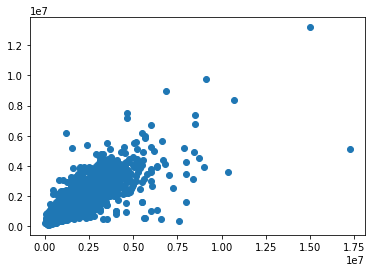

In [21]:
import matplotlib.pyplot as plt
plt.scatter(y_validation, predictions)